# Telco Customer Churn Analysis

This notebook analyzes customer churn data to develop a predictive model using deep learning. Various data processing, balancing, and model training techniques are applied.

## Step 1: Importing Required Libraries

In [1]:

# Import libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


## Step 2: Loading the Data

In [2]:

# Load the Telco Customer Churn dataset
data = pd.read_excel('Telco_customer_churn.xlsx')
data.head()


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## Step 3: Data Overview and Basic Information

In [3]:

# Define a function to get data structure, types, unique values, and nulls for each column
def data_info(data):
    cols = []
    unique_val = []
    n_uniques = []
    dtypes = []
    nulls = []
    for col in data.columns:
        cols.append(col)
        dtypes.append(data[col].dtype)
        n_uniques.append(data[col].nunique())
        unique_val.append(data[col].unique())
        nulls.append(data[col].isna().sum())
        
    return pd.DataFrame({
        "Column": cols,
        "Data Type": dtypes,
        "Unique Values Count": n_uniques,
        "Unique Values": unique_val,
        "Null Count": nulls
    })

# Display dataset information
data_info(data)


,Column,Data Type,Unique Values Count,Unique Values,Null Count
0,CustomerID,object,7043,"[3668-QPYBK, 9237-HQITU, 9305-CDSKC, 7892-POOK...",0
1,Count,int64,1,[1],0
2,Country,object,1,[United States],0
3,State,object,1,[California],0
4,City,object,1129,"[Los Angeles, Beverly Hills, Huntington Park, ...",0
5,Zip Code,int64,1652,"[90003, 90005, 90006, 90010, 90015, 90020, 900...",0
6,Lat Long,object,1652,"[33.964131, -118.272783, 34.059281, -118.30742...",0
7,Latitude,float64,1652,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",0
8,Longitude,float64,1651,"[-118.272783, -118.30742, -118.293953, -118.31...",0
9,Gender,object,2,"[Male, Female]",0


## Step 4: Data Cleaning

In [4]:

# Drop columns that are not relevant for analysis
data.drop(['CustomerID', 'Churn Label', 'Count', 'Country', 'State', 'Zip Code', 'Lat Long', 'City'], axis=1, inplace=True)


In [5]:
data.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,Churn Reason
0,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,86,3239,Competitor made better offer
1,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,67,2701,Moved
2,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,...,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1,86,5372,Moved
3,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,...,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,84,5003,Moved
4,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,...,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1,89,5340,Competitor had better devices


In [6]:
data_info(data)

,Column,Data Type,Unique Values Count,Unique Values,Null Count
0,Latitude,float64,1652,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",0
1,Longitude,float64,1651,"[-118.272783, -118.30742, -118.293953, -118.31...",0
2,Gender,object,2,"[Male, Female]",0
3,Senior Citizen,object,2,"[No, Yes]",0
4,Partner,object,2,"[No, Yes]",0
5,Dependents,object,2,"[No, Yes]",0
6,Tenure Months,int64,73,"[2, 8, 28, 49, 10, 1, 47, 17, 5, 34, 11, 15, 1...",0
7,Phone Service,object,2,"[Yes, No]",0
8,Multiple Lines,object,3,"[No, Yes, No phone service]",0
9,Internet Service,object,3,"[DSL, Fiber optic, No]",0


In [7]:
le=LabelEncoder()
data['Contract']=le.fit_transform(data['Contract'])

In [8]:
data['Churn Value'].value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

In [9]:
data['Churn Reason'].value_counts()

Churn Reason
Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Limited range of services                     44
Long distance charges                         44
Lack of affordable download/upload speed      44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: c

In [10]:
data['Churn Reason'].fillna("not leave",inplace=True)

In [11]:
data_info(data)

,Column,Data Type,Unique Values Count,Unique Values,Null Count
0,Latitude,float64,1652,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",0
1,Longitude,float64,1651,"[-118.272783, -118.30742, -118.293953, -118.31...",0
2,Gender,object,2,"[Male, Female]",0
3,Senior Citizen,object,2,"[No, Yes]",0
4,Partner,object,2,"[No, Yes]",0
5,Dependents,object,2,"[No, Yes]",0
6,Tenure Months,int64,73,"[2, 8, 28, 49, 10, 1, 47, 17, 5, 34, 11, 15, 1...",0
7,Phone Service,object,2,"[Yes, No]",0
8,Multiple Lines,object,3,"[No, Yes, No phone service]",0
9,Internet Service,object,3,"[DSL, Fiber optic, No]",0


In [12]:
data['Total Charges']=pd.to_numeric(data['Total Charges'],errors='coerce')

In [13]:
data['Total Charges'].isna().sum()

11

In [14]:
data['Total Charges'].fillna(data['Total Charges'].mean(),inplace=True)

In [15]:
data_info(data)

,Column,Data Type,Unique Values Count,Unique Values,Null Count
0,Latitude,float64,1652,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",0
1,Longitude,float64,1651,"[-118.272783, -118.30742, -118.293953, -118.31...",0
2,Gender,object,2,"[Male, Female]",0
3,Senior Citizen,object,2,"[No, Yes]",0
4,Partner,object,2,"[No, Yes]",0
5,Dependents,object,2,"[No, Yes]",0
6,Tenure Months,int64,73,"[2, 8, 28, 49, 10, 1, 47, 17, 5, 34, 11, 15, 1...",0
7,Phone Service,object,2,"[Yes, No]",0
8,Multiple Lines,object,3,"[No, Yes, No phone service]",0
9,Internet Service,object,3,"[DSL, Fiber optic, No]",0


In [16]:
data_info(data)

,Column,Data Type,Unique Values Count,Unique Values,Null Count
0,Latitude,float64,1652,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",0
1,Longitude,float64,1651,"[-118.272783, -118.30742, -118.293953, -118.31...",0
2,Gender,object,2,"[Male, Female]",0
3,Senior Citizen,object,2,"[No, Yes]",0
4,Partner,object,2,"[No, Yes]",0
5,Dependents,object,2,"[No, Yes]",0
6,Tenure Months,int64,73,"[2, 8, 28, 49, 10, 1, 47, 17, 5, 34, 11, 15, 1...",0
7,Phone Service,object,2,"[Yes, No]",0
8,Multiple Lines,object,3,"[No, Yes, No phone service]",0
9,Internet Service,object,3,"[DSL, Fiber optic, No]",0


In [17]:
data=pd.get_dummies(data,drop_first=True)
data.head()

,Latitude,Longitude,Tenure Months,Contract,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,Gender_Male,...,Churn Reason_Limited range of services,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction,Churn Reason_not leave
0,33.964131,-118.272783,2,0,53.85,108.15,1,86,3239,True,...,False,False,False,False,False,False,False,False,False,False
1,34.059281,-118.307420,2,0,70.70,151.65,1,67,2701,False,...,False,False,True,False,False,False,False,False,False,False
2,34.048013,-118.293953,8,0,99.65,820.50,1,86,5372,False,...,False,False,True,False,False,False,False,False,False,False
3,34.062125,-118.315709,28,0,104.80,3046.05,1,84,5003,False,...,False,False,True,False,False,False,False,False,False,False
4,34.039224,-118.266293,49,0,103.70,5036.30,1,89,5340,True,...,False,False,False,False,False,False,False,False,False,False


In [18]:
X=data.drop(['Churn Value'],axis=1).values
y=data['Churn Value'].values

In [19]:
ros = SMOTE(random_state=42)
X,y = ros.fit_resample(X, y)
Counter(y)

Counter({1: 5174, 0: 5174})

In [20]:
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2)

In [21]:
#fearture scaling 
sd=StandardScaler()
train_X=sd.fit_transform(train_X)
test_X=sd.transform(test_X)

## Model

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=10,           
    restore_best_weights=True 
)

def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(train_X.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model


In [23]:
optimizer_types = ['adam', 'sgd', 'adagrad', 'rmsprop']

def get_optimizer(optimizer_type):
    if optimizer_type == 'adam':
        return Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99)
    elif optimizer_type == 'sgd':
        return SGD(learning_rate=lr_schedule)
    elif optimizer_type == 'adagrad':
        return Adagrad(learning_rate=lr_schedule)
    else:
        return RMSprop(learning_rate=lr_schedule)

In [24]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)


Training with optimizer: adam
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8003 - loss: 0.4735 - val_accuracy: 0.9879 - val_loss: 0.0927
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9924 - loss: 0.0562 - val_accuracy: 0.9964 - val_loss: 0.0154
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9987 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9999 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 9.9541e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 7.0834e-04 - val_accuracy: 1.0000 - val_loss: 9.2213e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss

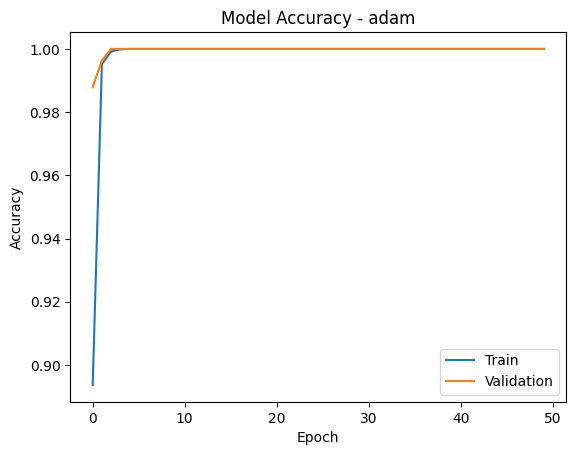

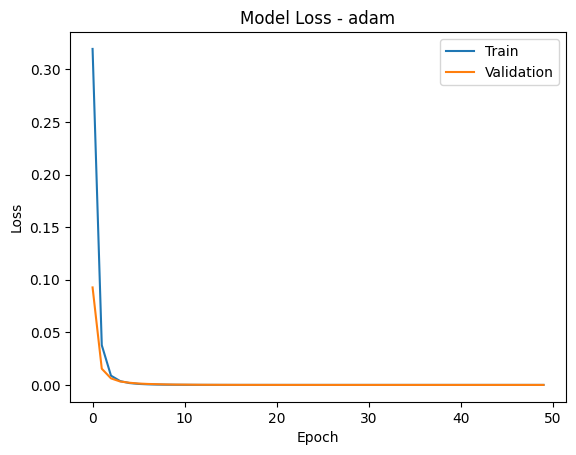

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 1.0000 - loss: 3.0891e-09
Test Accuracy with adam: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1030
           1       1.00      1.00      1.00      1040

    accuracy                           1.00      2070
   macro avg       1.00      1.00      1.00      2070
weighted avg       1.00      1.00      1.00      2070



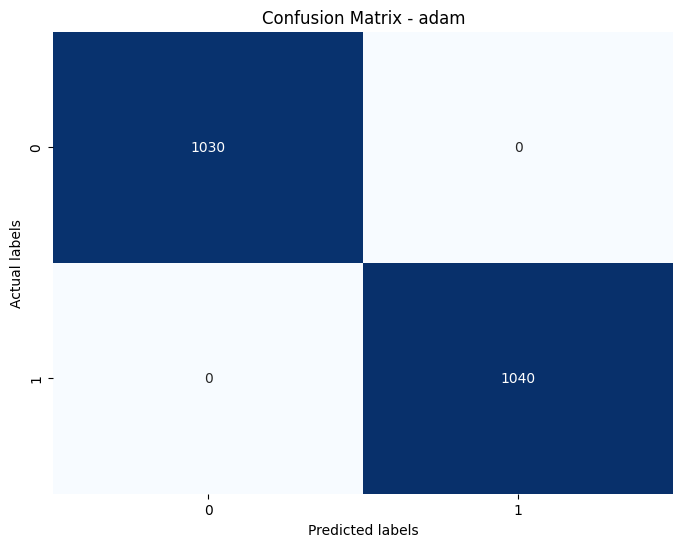


Training with optimizer: sgd
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4721 - loss: 0.7553 - val_accuracy: 0.4710 - val_loss: 0.7415
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4948 - loss: 0.7168 - val_accuracy: 0.5495 - val_loss: 0.6920
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5678 - loss: 0.6664 - val_accuracy: 0.6002 - val_loss: 0.6519
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6286 - loss: 0.6310 - val_accuracy: 0.6401 - val_loss: 0.6185
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6725 - loss: 0.6024 - val_accuracy: 0.6800 - val_loss: 0.5897
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7084 - loss: 0.5751 - val_accuracy: 0.7198 - val_loss: 0.5646
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.7375 - loss: 0.5476 - val_accuracy: 0.7391 - val_loss: 0.5418
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7567 - loss: 0.5297 - 

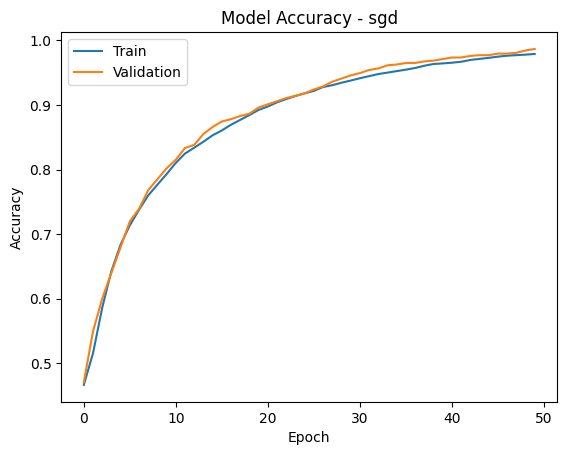

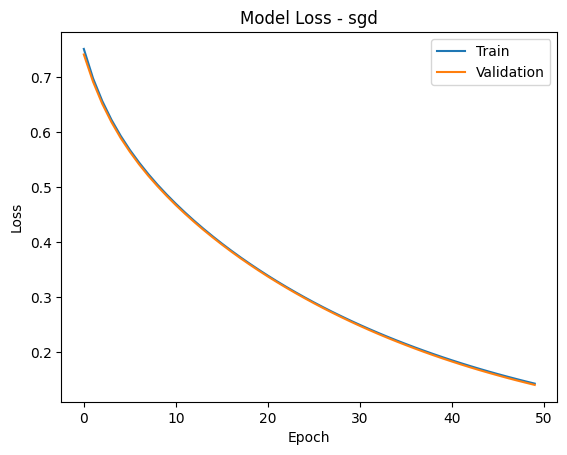

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.9766 - loss: 0.1389
Test Accuracy with sgd: 0.97
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1030
           1       0.98      0.96      0.97      1040

    accuracy                           0.97      2070
   macro avg       0.97      0.97      0.97      2070
weighted avg       0.97      0.97      0.97      2070



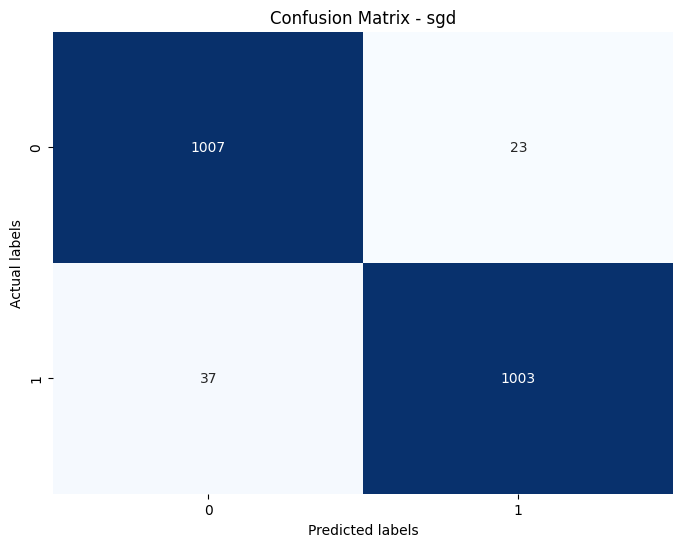


Training with optimizer: adagrad
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4236 - loss: 0.7786 - val_accuracy: 0.4469 - val_loss: 0.7225
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4917 - loss: 0.7046 - val_accuracy: 0.5435 - val_loss: 0.6654
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5782 - loss: 0.6504 - val_accuracy: 0.6522 - val_loss: 0.6231
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6566 - loss: 0.6132 - val_accuracy: 0.7005 - val_loss: 0.5897
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7129 - loss: 0.5771 - val_accuracy: 0.7283 - val_loss: 0.5611
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7394 - loss: 0.5523 - val_accuracy: 0.7500 - val_loss: 0.5355
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7698 - loss: 0.5238 - val_accuracy: 0.7729 - val_loss: 0.5119
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7890 - loss: 0.5028 

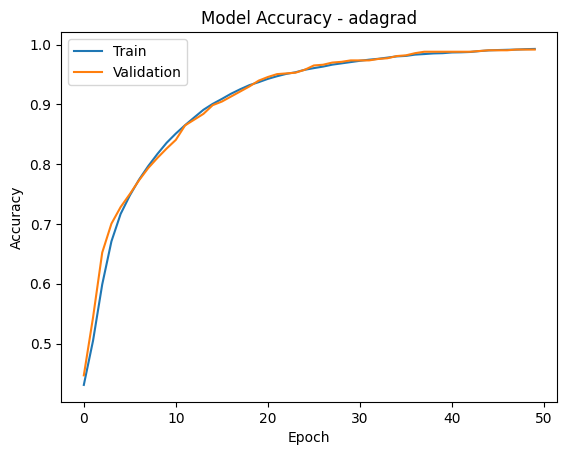

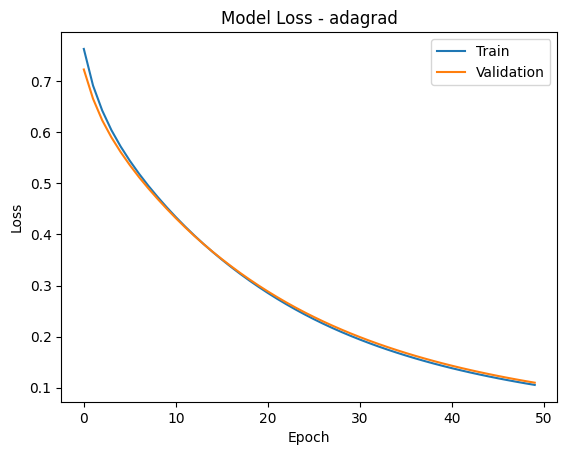

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9938 - loss: 0.1031  
Test Accuracy with adagrad: 0.99
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1030
           1       0.99      1.00      0.99      1040

    accuracy                           0.99      2070
   macro avg       0.99      0.99      0.99      2070
weighted avg       0.99      0.99      0.99      2070



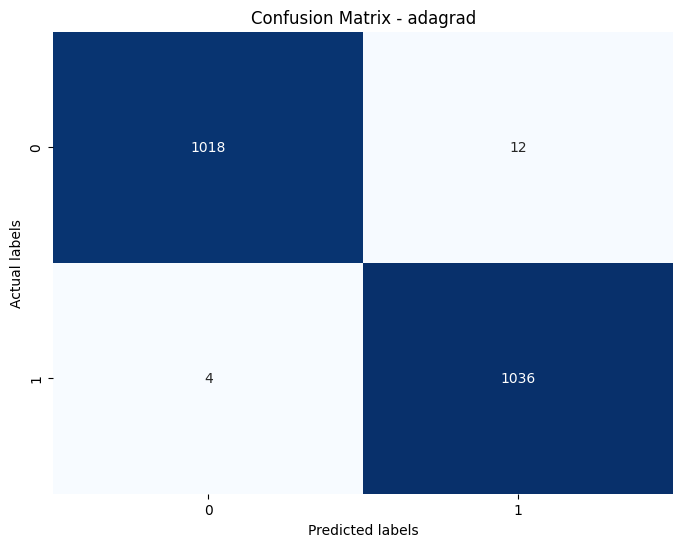


Training with optimizer: rmsprop
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7723 - loss: 0.4835 - val_accuracy: 0.9952 - val_loss: 0.0825
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9957 - loss: 0.0468 - val_accuracy: 0.9976 - val_loss: 0.0117
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0060 - val_accuracy: 0.9988 - val_loss: 0.0038
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.9987e-04 - val_accuracy: 0.9988 - val_loss: 0.0017
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.3723e-04 - val_accuracy: 0.9988 - val_loss: 0.0012
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.1179e-04 - val_accuracy: 1.0000 - val_loss: 9.4485e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.1562e-05 - val_accuracy: 1.0000 - val_loss: 8.5683e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

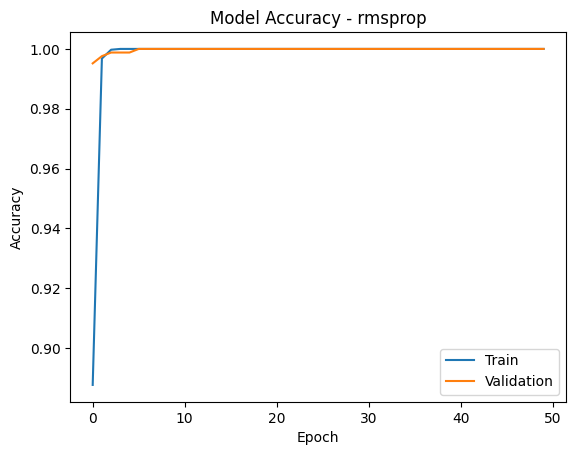

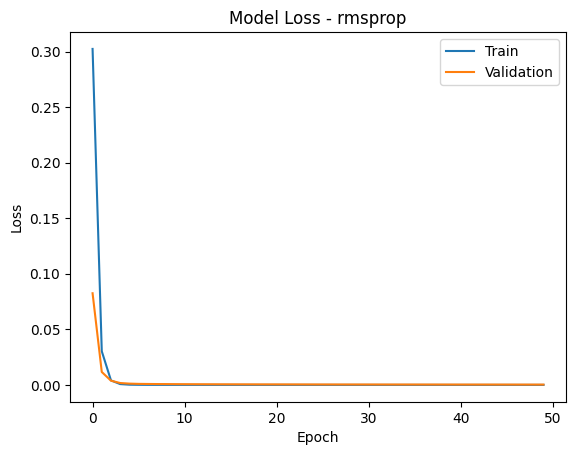

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 1.0000 - loss: 5.8450e-06
Test Accuracy with rmsprop: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1030
           1       1.00      1.00      1.00      1040

    accuracy                           1.00      2070
   macro avg       1.00      1.00      1.00      2070
weighted avg       1.00      1.00      1.00      2070



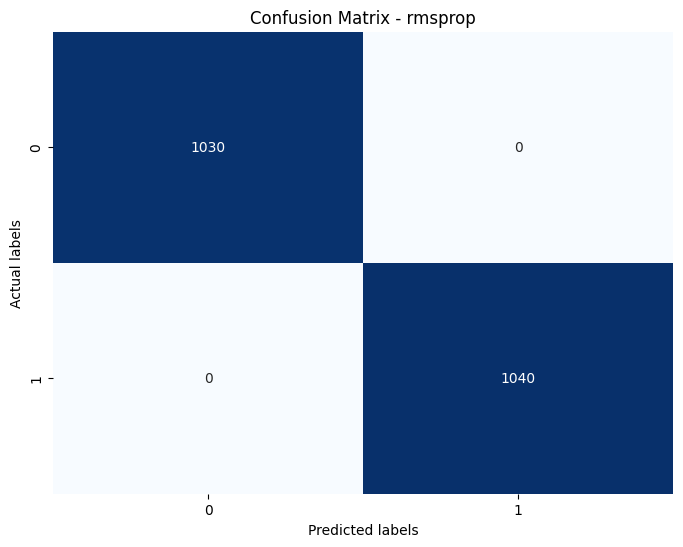

In [25]:
for opt_type in optimizer_types:
    print(f"\nTraining with optimizer: {opt_type}")
    
    # Build a new model for each optimizer
    model = build_model()
    
    # Compile model with the current optimizer
    opt = get_optimizer(opt_type)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Fresh early stopping callback for each optimizer
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(train_X, train_y, validation_split=0.1, batch_size=128, epochs=50, callbacks=[early_stopping])
    
    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.legend()
    plt.title(f'Model Accuracy - {opt_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Plot loss
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend()
    plt.title(f'Model Loss - {opt_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Predict and evaluate
    y_pred = model.predict(test_X)
    y_p = [1 if i > 0.5 else 0 for i in y_pred]
    
    # Evaluate model
    accuracy = model.evaluate(test_X, test_y)[1]
    print(f'Test Accuracy with {opt_type}: {accuracy:.2f}')
    print(classification_report(test_y, y_p))
    
    # Confusion matrix
    cm = confusion_matrix(test_y, y_p)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {opt_type}')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.show()